# Combine all the data into once dataset

Once you've run the following notebooks,
- 01_stt_pecha_tools.ipynb
- 02_prodigy.ipynb
- 03_mv_saymore.ipynb

You get the following tsv files
- 01_stt_pecha_tools.tsv
- 02_prodigy.tsv
- 03_mv_saymore.tsv

Concatenate the tsv files and clean the data

In [1]:
stt_pecha_tools = "01_stt_pecha_tools.csv"
prodigy =         "02_prodigy_finalised.csv"

In [2]:
import pandas as pd
pecha_tools_df = pd.read_csv(stt_pecha_tools)
prodigy_df = pd.read_csv(prodigy)

In [3]:
prodigy_df = prodigy_df.rename(columns={'id': 'file_name', 'transcript':'uni'})

In [4]:
df = pd.concat([pecha_tools_df, prodigy_df], ignore_index=True)

In [5]:
bad_apples = pd.read_csv('04_bad_apples.csv')

In [6]:
df = df[~df['file_name'].isin(bad_apples['file_name'])]

Drop duplicates, duplicates were introduced from prodigy annotation tool. One of the reason we had to move away from it.

In [7]:
df.drop_duplicates(subset='file_name', keep="first", inplace=True)

### clean the combined tsv

Remove unwanted characters and remove transcriptions with english characters

In [8]:
import re
def clean_transcription(text):
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.strip()
    
    text = re.sub("༌", "་",text) # there are two type of 'tsak' let's normalize 0xf0b to 0xf0c
    text = re.sub("༎", "།",text) # normalize double 'shae' 0xf0e to 0xf0d
    
    text = re.sub("ཽ", "ོ",text) # normalize
    text = re.sub("ཻ", "ེ",text) # normalize "᫥"
    
    text = re.sub(r"\s+།", "།", text)
    text = re.sub(r"།+", "།", text)
    text = re.sub(r"།", "། ", text)
    text = re.sub(r"\s+་", "་", text)
    text = re.sub(r"་+", "་", text)
    text = re.sub(r"\s+", " ", text)
    
    text = re.sub(r"ཧཧཧ+", "ཧཧཧ", text)
    # text = re.sub(r'འེ་འེ་(འེ་)+', r'འེ་འེ་འེ་', text)
    text = re.sub(r'ཧ་ཧ་(ཧ་)+', r'ཧ་ཧ་ཧ་', text)

    chars_to_ignore_regex = "[\,\?\.\!\-\;\:\"\“\%\‘\”\�\/\{\}\(\)༽》༼《༅༄༈༑༠'|·×༆༔༷༸༾ཿ྄྅྆྇ྋ࿒ᨵ​’„╗╚᫥ྂ]"
    text = re.sub(chars_to_ignore_regex, '', text)+" "
    return text

def check_if_regex(text):
    text = str(text)
    regex = re.compile(r'[a-zA-Z]+')
    match = re.search(regex, text)
    
    return bool(match)
    
print(clean_transcription('ཧཧཧཧ་  ཧ་ ཧ་ཧ་།   འ་༽འ་××འ༌༌༌༌༌༌༌གྲོ།ཚ ར་སོང་ངེ་། '))

False
True


In [9]:
df = df[df['uni'].str.len() > 0]

In [10]:
df = df[~df['uni'].apply(check_if_regex)]

In [11]:
df['uni'] = df['uni'].map(clean_transcription)

In [12]:
from datasets import Dataset
common_voice_train = Dataset.from_pandas(df)

In [13]:
def extract_all_chars(batch):
    all_text = " ".join(batch["uni"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [14]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)

Map:   0%|          | 0/721058 [00:00<?, ? examples/s]

In [15]:
vocab_list = list(set(vocab_train["vocab"][0]))

In [16]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

In [17]:
all = ''
for c in vocab_dict:
    all += c

In [19]:
sorted(all)
print("num of unique chars:", len(all))
x="  ".join([str(i) for i in sorted(all)])
print(x)

print()

x="ཨ".join([str(i) for i in sorted(all)])
print(x)

num of unique chars: 103
   ༀ  ་  །  ༡  ༢  ༣  ༤  ༥  ༦  ༧  ༨  ༩  ཀ  ཁ  ག  གྷ  ང  ཅ  ཆ  ཇ  ཉ  ཊ  ཋ  ཌ  ཌྷ  ཎ  ཏ  ཐ  ད  དྷ  ན  པ  ཕ  བ  བྷ  མ  ཙ  ཚ  ཛ  ཝ  ཞ  ཟ  འ  ཡ  ར  ལ  ཤ  ཥ  ས  ཧ  ཨ  ཀྵ  ཪ  ཱ  ི  ཱི  ུ  ཱུ  ཷ  ེ  ོ  ཾ  ྀ  ཱྀ  ྃ  ྐ  ྑ  ྒ  ྔ  ྕ  ྖ  ྗ  ྙ  ྚ  ྛ  ྜ  ྞ  ྟ  ྠ  ྡ  ྡྷ  ྣ  ྤ  ྥ  ྦ  ྦྷ  ྨ  ྩ  ྪ  ྫ  ྭ  ྰ  ྱ  ྲ  ླ  ྴ  ྵ  ྶ  ྷ  ྸ  ྻ  ྼ

 ཨༀཨ་ཨ།ཨ༡ཨ༢ཨ༣ཨ༤ཨ༥ཨ༦ཨ༧ཨ༨ཨ༩ཨཀཨཁཨགཨགྷཨངཨཅཨཆཨཇཨཉཨཊཨཋཨཌཨཌྷཨཎཨཏཨཐཨདཨདྷཨནཨཔཨཕཨབཨབྷཨམཨཙཨཚཨཛཨཝཨཞཨཟཨའཨཡཨརཨལཨཤཨཥཨསཨཧཨཨཨཀྵཨཪཨཱཨིཨཱིཨུཨཱུཨཷཨེཨོཨཾཨྀཨཱྀཨྃཨྐཨྑཨྒཨྔཨྕཨྖཨྗཨྙཨྚཨྛཨྜཨྞཨྟཨྠཨྡཨྡྷཨྣཨྤཨྥཨྦཨྦྷཨྨཨྩཨྪཨྫཨྭཨྰཨྱཨྲཨླཨྴཨྵཨྶཨྷཨྸཨྻཨྼ


In [ ]:
! pip install pyewts

### Convert unicode tibetan characters into wylie format

In [20]:
import pyewts

converter = pyewts.pyewts()

df['wylie'] = df['uni'].apply(converter.toWylie)

In [21]:
df['char_len'] = df['uni'].str.len()

In [ ]:
! pip install matplotlib

<Axes: >

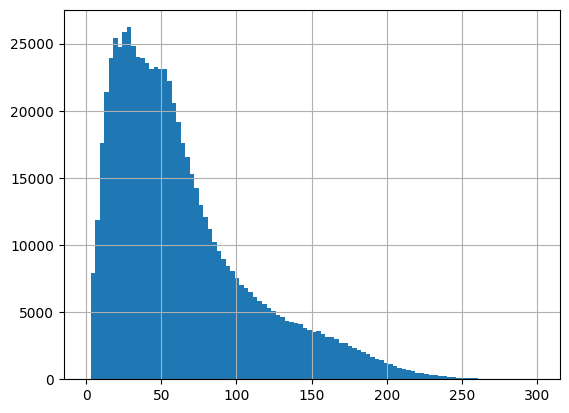

In [22]:
df['char_len'].hist(bins=100, range=(0, 300))

In [23]:
df['char_len'].describe()

count    721058.000000
mean         63.667956
std          46.416247
min           1.000000
25%          29.000000
50%          52.000000
75%          85.000000
max         385.000000
Name: char_len, dtype: float64

In [24]:
df.shape[0]

721058

In [25]:
upper_cutoff = 400
lower_cutoff = 5

In [26]:
df[df['char_len'] > upper_cutoff].shape[0], df[df['char_len'] < lower_cutoff].shape[0]

(0, 6032)

In [28]:
df[df['char_len'] > upper_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_longer_than_upper_cutoff.csv', index=False)

In [29]:
df[df['char_len'] < lower_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_shorter_than_lower_cutoff.csv', index=False)

In [30]:
df = df[(df['char_len'] < upper_cutoff) & (df['char_len'] > lower_cutoff)]

In [31]:
df.shape[0]

713118

### Get the audio time duration from the file name. 

There is to format for encoding the time span. We use the one with \_to\_ now. The difference came from the using a different library to do the Voice Activity Detection and splitting the audio for Tibetan Teachings. We have since started using pyannote-audio for all departments now.

In [32]:
def getTimeSpan(filename):

    filename = filename.replace(".wav", "")
    filename = filename.replace(".WAV", "")
    filename = filename.replace(".mp3", "")
    filename = filename.replace(".MP3", "")
    try:
        if "_to_" in filename:
            start, end = filename.split("_to_")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end = float(end)
            start = float(start)
            return abs(end - start)/1000
        else:
            start, end = filename.split("-")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end =   float(end)
            start = float(start)
            return abs(end - start)
    except Exception as err:
        print(f"filename is:'{filename}'. Could not parse to get time span.")
        return 0
    

getTimeSpan("STT_TT00031_03471.850-03477.44")

5.5900000000001455

In [33]:
df['audio_len'] = df['file_name'].apply(getTimeSpan)

In [34]:
df['audio_len'].describe()

count    713118.000000
mean          3.451421
std           2.631261
min           0.200000
25%           1.500000
50%           2.560000
75%           4.625000
max          13.650000
Name: audio_len, dtype: float64

<Axes: >

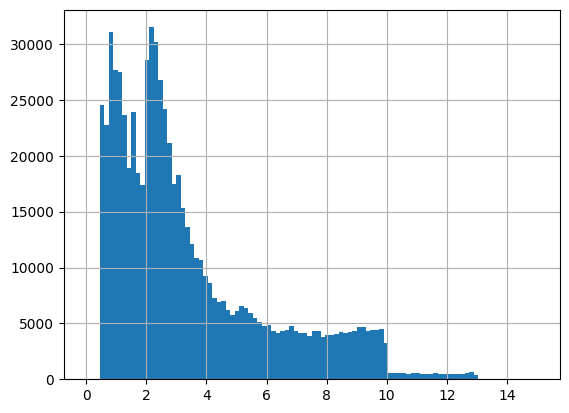

In [35]:
df['audio_len'].hist(bins=100, range=(0, 15))

In [36]:
df['url'] = 'https://d38pmlk0v88drf.cloudfront.net/wav16k/' + df['file_name'] + '.wav'

In [37]:
df['url'] = df['url'].map(lambda x : x.replace('#','%23'))

In [38]:
df = df[['file_name','uni', 'wylie', 'url', 'dept', 'grade', 'char_len',  'audio_len']]

In [39]:
df.head()

,file_name,uni,wylie,url,dept,grade,char_len,audio_len
0,STT_NS_M0321_0472_3336783_to_3340138,སྔོན་འགོག་མ་བྱས་བ་ཡིན་ན་ལབ་དགོས་རཱ།ད་སྔོན་ནས་ཁ...,sngon 'gog ma byas ba yin na lab dgos rA/da sn...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,86,3.355
1,STT_NS_M0321_0482_3402953_to_3405182,འབེལ་འབེལ་ལྷུག་ལྷུག་ཡོད་རཱ།སོ་སོ་ག་རེ་བཟའ་ན་ཡང...,'bel 'bel lhug lhug yod rA/so so ga re bza' na...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,65,2.229
2,STT_NS_M0068_0003_15600_to_21102,དྲི་བ་འདི་ཡོད་བ་ཏོག་ཙི་དཀའ་ལས་ཁག་པོ་འདྲ་བོ་ཞིག...,dri ba 'di yod ba tog tsi dka' las khag po 'dr...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,2.0,106,5.502
3,STT_NS_M0311_0108_714701_to_719069,ད་ང་རང་ཡང་མོ་ཡག་པོ་ཡོད་རེད།མོ་ལག་པ་ཤང་པོ་ཡོད་ར...,da nga rang yang mo yag po yod red/mo lag pa s...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,89,4.368
4,STT_NS_M0311_0120_793916_to_797602,ཨེ་ནས་ཨ་རག་དང་ཨེ་འདྲའི་འདྲ་བོ་ལོངས་སྤྱོད་འདྲ་བ...,e nas a rag dang e 'dra'i 'dra bo longs spyod ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,61,3.686


In [40]:
df.to_csv('04_combine_all.csv', index=False)

In [41]:
! aws s3 cp 04_combine_all.csv s3://monlam.ai.stt/tsv/04_combine_all.csv

upload: ./04_combine_all.csv to s3://monlam.ai.stt/tsv/04_combine_all.csv


In [42]:
! aws s3 cp 04_bad_apples.csv s3://monlam.ai.stt/tsv/04_bad_apples.csv

upload: ./04_bad_apples.csv to s3://monlam.ai.stt/tsv/04_bad_apples.csv


In [40]:
df['uni'].str.contains('ཧཧཧ').value_counts()

uni
False    713014
True        104
Name: count, dtype: int64

In [139]:
import pandas as pd

df = pd.read_csv('04_combine_all.csv')

#### Hours in each department

In [41]:
df.groupby('dept')['audio_len'].sum()/60/60

dept
STT_AB    113.049924
STT_CS     98.375647
STT_MV      8.113259
STT_NS    173.804951
STT_PC     15.606155
STT_TT    274.736280
Name: audio_len, dtype: float64

#### Total hours

In [42]:
df['audio_len'].sum()/60/60

683.6862161111112

In [143]:
# df.sort_values(by='audio_len', ascending=False, inplace=True)
df = df.sample(frac = 1)

In [44]:
df.iloc[0:100,[0, 1, 3, 5]].to_csv("04_random_100.csv", index=False)
df.iloc[0:100,[0, 1, 3, 5]].head()

,file_name,uni,url,grade
0,STT_NS_M0321_0472_3336783_to_3340138,སྔོན་འགོག་མ་བྱས་བ་ཡིན་ན་ལབ་དགོས་རཱ།ད་སྔོན་ནས་ཁ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
1,STT_NS_M0321_0482_3402953_to_3405182,འབེལ་འབེལ་ལྷུག་ལྷུག་ཡོད་རཱ།སོ་སོ་ག་རེ་བཟའ་ན་ཡང...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
2,STT_NS_M0068_0003_15600_to_21102,དྲི་བ་འདི་ཡོད་བ་ཏོག་ཙི་དཀའ་ལས་ཁག་པོ་འདྲ་བོ་ཞིག...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,2.0
3,STT_NS_M0311_0108_714701_to_719069,ད་ང་རང་ཡང་མོ་ཡག་པོ་ཡོད་རེད།མོ་ལག་པ་ཤང་པོ་ཡོད་ར...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
4,STT_NS_M0311_0120_793916_to_797602,ཨེ་ནས་ཨ་རག་དང་ཨེ་འདྲའི་འདྲ་བོ་ལོངས་སྤྱོད་འདྲ་བ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0


In [45]:
df[df['grade'] == 3].groupby('dept').size()

dept
STT_AB     26132
STT_CS     22699
STT_NS     78979
STT_PC      6036
STT_TT    129288
dtype: int64